<a href="https://colab.research.google.com/github/noahstammm/ml2_project/blob/main/Food_detection_to_recipes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import all libraries

In [3]:
import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU
from tensorflow import keras
from tensorflow.keras import models
import cv2

### Prepare data and create data structure

First check the GPU

In [4]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0



Define the path were the folder should be created and created folders which are necessary to load the data later on.

In [5]:
# Definieren Sie den Pfad zum Hauptordner
base_dir = "/content/kaggle"

# Erstellen Sie den Hauptordner, wenn er noch nicht vorhanden ist
if not os.path.exists(base_dir):
    os.makedirs(base_dir)

# Definieren Sie den Pfad zu den Unterordnern
folder_input = os.path.join(base_dir, "input")
folder_food = os.path.join(folder_input, "food-101")

# Erstellen Sie die Unterordner, wenn sie noch nicht vorhanden sind
if not os.path.exists(folder_input):
    os.makedirs(folder_input)
if not os.path.exists(folder_food):
    os.makedirs(folder_food)


Define path where the data should be extracted

In [6]:
%cd /content/kaggle/input/food-101/

/content/kaggle/input/food-101


Helper function which create another folder and checks if already on exists. Then download the dataset. Note that it will take a couple of minutes to download the data.

In [7]:
# Helper function to download data and extract
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

# Download data and extract it to folder
# Uncomment this below line if you are on Colab

get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

In [8]:
# Check the extracted dataset folder
!ls food-101/
os.listdir('food-101/images')

images	license_agreement.txt  meta  README.txt


['beef_tartare',
 'baby_back_ribs',
 'tacos',
 'gyoza',
 'bibimbap',
 'waffles',
 'chocolate_mousse',
 'fish_and_chips',
 'bread_pudding',
 'pulled_pork_sandwich',
 'pad_thai',
 'cheesecake',
 'lasagna',
 'oysters',
 'chicken_curry',
 'filet_mignon',
 'seaweed_salad',
 'onion_rings',
 'takoyaki',
 'chicken_wings',
 'pizza',
 'poutine',
 'spring_rolls',
 'spaghetti_bolognese',
 'fried_calamari',
 'risotto',
 'panna_cotta',
 'prime_rib',
 'churros',
 'carrot_cake',
 'ravioli',
 'paella',
 'steak',
 'clam_chowder',
 'cannoli',
 'pho',
 'caesar_salad',
 'club_sandwich',
 'nachos',
 'macarons',
 'hot_dog',
 'pork_chop',
 'lobster_bisque',
 'lobster_roll_sandwich',
 'chicken_quesadilla',
 'peking_duck',
 'hot_and_sour_soup',
 'apple_pie',
 'creme_brulee',
 'guacamole',
 'deviled_eggs',
 'ceviche',
 'fried_rice',
 'falafel',
 'edamame',
 'baklava',
 'samosa',
 'tiramisu',
 'breakfast_burrito',
 'escargots',
 'spaghetti_carbonara',
 'caprese_salad',
 'french_toast',
 'cup_cakes',
 'dumplings',

Visualize the datas, showing every image per class and its classname

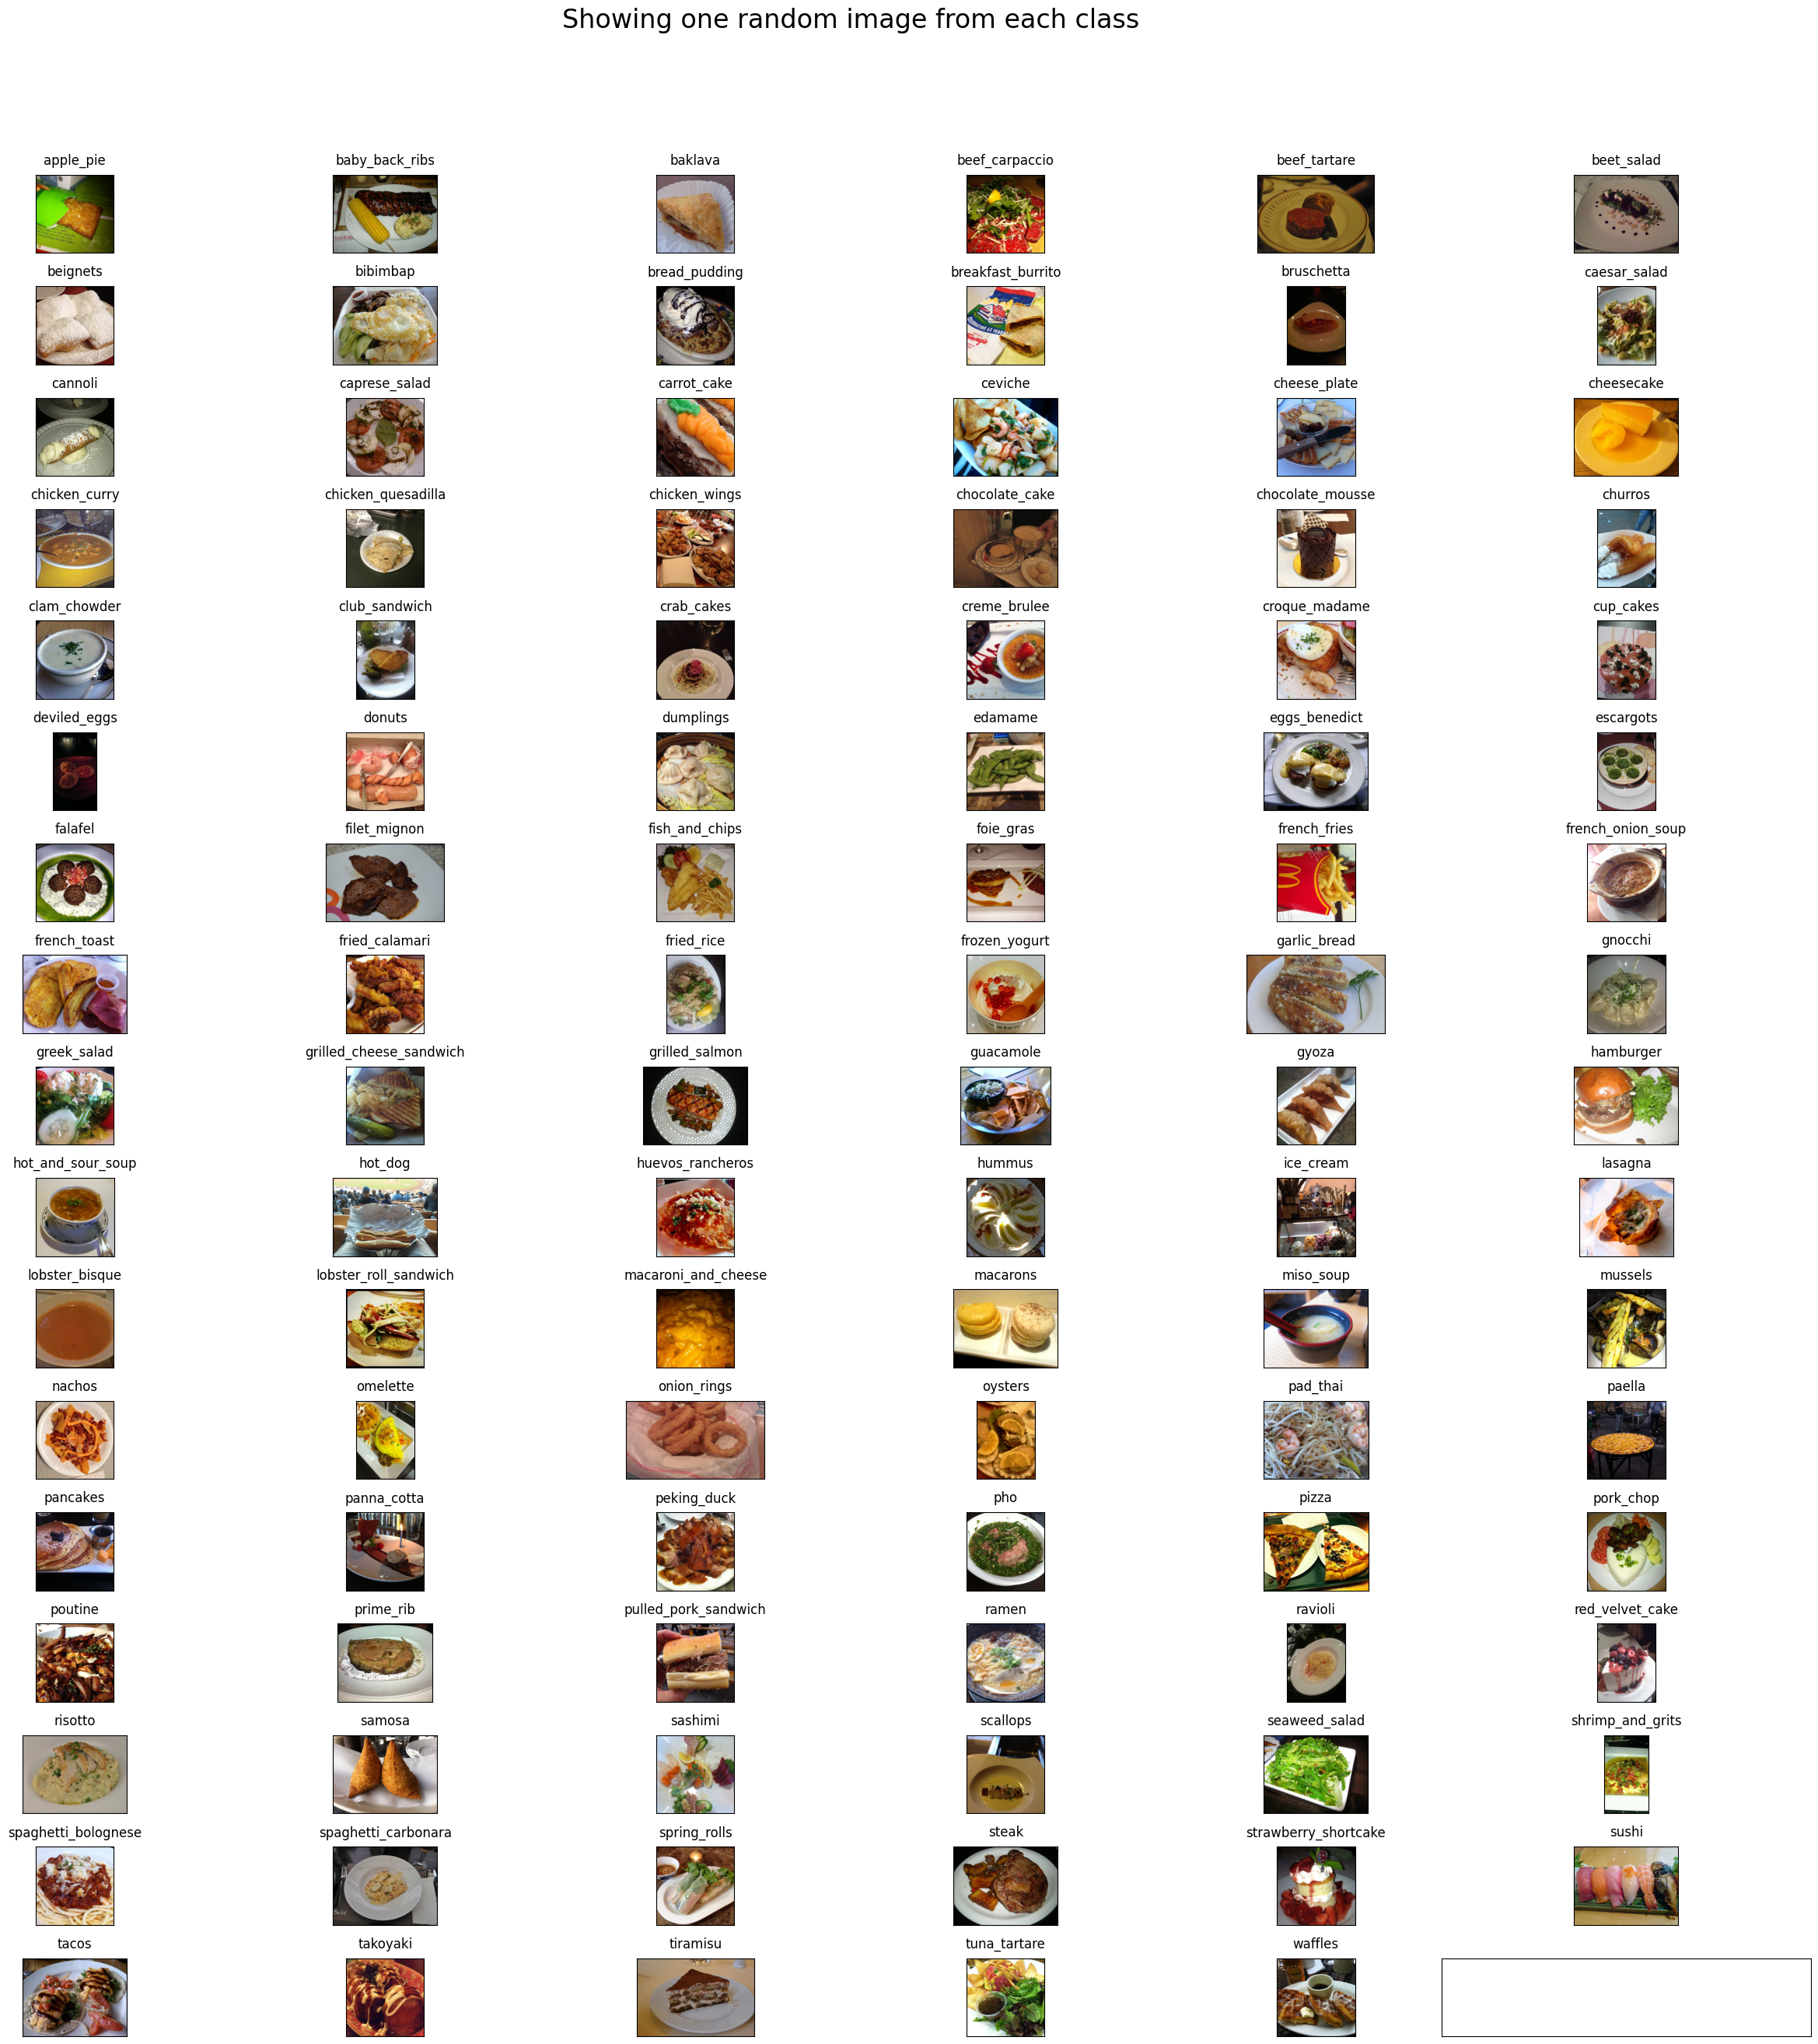

In [9]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()


### Split data in training and test folders
Now we split the data in training and test folders for this we copying the data from the original dataset to the training and test folders


In [10]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [11]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
%cd /
print("Creating train data...")
prepare_data('/content/kaggle/input/food-101/food-101/meta/train.txt', '/content/kaggle/input/food-101/food-101/images', 'train')

/
Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying 

In [12]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('/content/kaggle/input/food-101/food-101/meta/test.txt', '/content/kaggle/input/food-101/food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [13]:
# Check how many files are in the train folder
print("Total number of samples in train folder")
!find train -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
75750


In [14]:
# Check how many files are in the test folder
print("Total number of samples in test folder")
!find test -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
25250


In [16]:
# List of all 101 types of foods(sorted alphabetically)
del foods_sorted[0] # remove .DS_Store from the list

In [ ]:
foods_sorted

['baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster_roll_sandwich

Since the dataset is quite large, I have additionally split the data again into a mini-train and test dataset with only three classes

In [17]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))
      

In [18]:
# picking 3 food items and generating separate data folders for the same
food_list = ['apple_pie','pizza','omelette']
src_train = 'train'
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [19]:
# Copying the data again in the mini dataset folder for the training
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [20]:
# Print the total number of samples in train folder
print("Total number of samples in train folder")

!find train_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in train folder
2250


In [21]:
# Copying the data again in the mini dataset folder for the test
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette


In [22]:
# Print the total number of samples in test folder
print("Total number of samples in test folder")
!find test_mini -type d -or -type f -printf '.' | wc -c

Total number of samples in test folder
750


### Train the model InceptionV3 
The given code trains a model for classifying images using the Inception V3 model pre-trained on the ImageNet dataset.

I have deliberately chosen only 5 epochs here because the training is very time consuming. I also tried fewer epochs and got the best results with 2 and 5 epochs.






In [23]:
K.clear_session()
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.2)(x)
x = Dropout(0.3)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=2,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_3class.hdf5')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
87910968/87910968 [==============================] - 0s 0us/step


<ipython-input-23-eb481bf6dff0>:47: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/2
140/140 [==============================] - ETA: 0s - loss: 0.7407 - accuracy: 0.7059 
Epoch 1: val_loss improved from inf to 2.00042, saving model to best_model_3class.hdf5
140/140 [==============================] - 2760s 20s/step - loss: 0.7407 - accuracy: 0.7059 - val_loss: 2.0004 - val_accuracy: 0.5109
Epoch 2/2
140/140 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.8241 
Epoch 2: val_loss improved from 2.00042 to 0.56183, saving model to best_model_3class.hdf5
140/140 [==============================] - 2735s 20s/step - loss: 0.5203 - accuracy: 0.8241 - val_loss: 0.5618 - val_accuracy: 0.7853


<ipython-input-24-7f877c39bec3>:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  train_predictions = model.predict_generator(train_generator)
<ipython-input-24-7f877c39bec3>:13: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  test_predictions = model.predict_generator(validation_generator)


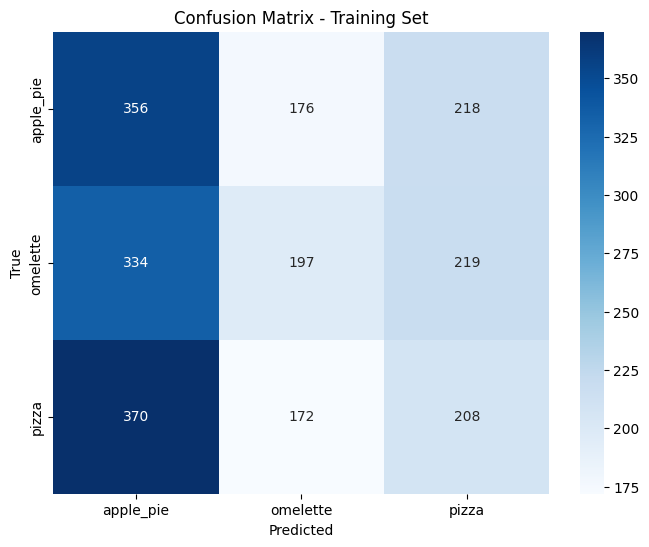

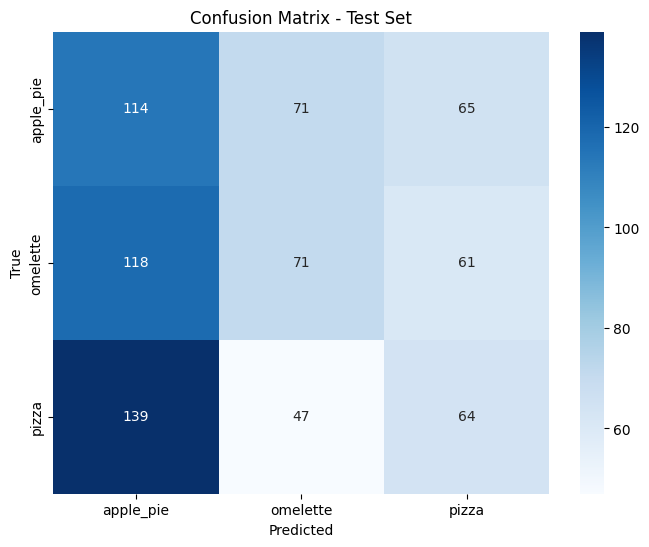

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the trained model
model = load_model('model_trained_3class.hdf5')

# Get the predictions for the training set
train_predictions = model.predict_generator(train_generator)
train_labels = train_generator.classes

# Get the predictions for the test set
test_predictions = model.predict_generator(validation_generator)
test_labels = validation_generator.classes

# Calculate the confusion matrix for the training set
train_cm = confusion_matrix(train_labels, np.argmax(train_predictions, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(train_cm, annot=True, cmap="Blues", fmt="d", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Training Set')
plt.show()

# Calculate the confusion matrix for the test set
test_cm = confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap="Blues", fmt="d", xticklabels=validation_generator.class_indices.keys(), yticklabels=validation_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()


In [ ]:
class_map_3 = train_generator.class_indices
class_map_3

{'apple_pie': 0, 'omelette': 1, 'pizza': 2}

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

### Visualize the training and test histrory 

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.xticks(range(0, len(history.history['accuracy'])+1, 6))  # Adjustment of the step size of the x-axis
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

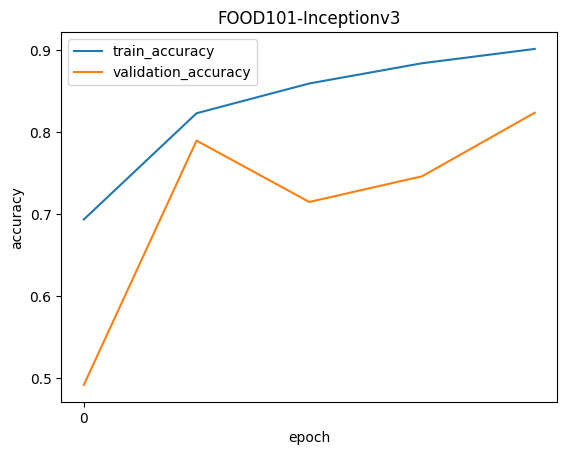

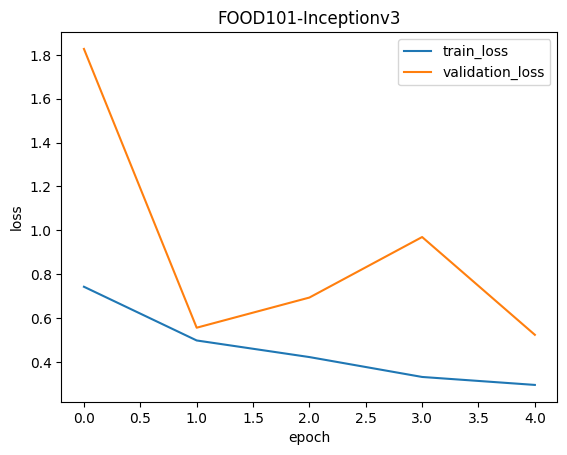

In [ ]:
plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

### Make a prediction on images from the internet

In [25]:
%%time
# Loading the best saved model to make predictions
K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 3.88 s, sys: 222 ms, total: 4.1 s
Wall time: 4.02 s


In [26]:
def predict_class(model, images, show = True):
  predictions = []  # Empty list for saving the predictions
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]

    predictions.append(pred_value)  # Add prediction to list
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
        
    return predictions

In [27]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O applepie.jpg https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg



--2023-06-02 14:16:09--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 45.77.209.234
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|45.77.209.234|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K  --.-KB/s    in 0.1s    

2023-06-02 14:16:10 (618 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2023-06-02 14:16:10--  https://acleanbake.com/wp-content/uploads/2017/10/Paleo-Apple-Pie-with-Crumb-Topping-gluten-free-grain-free-dairy-free-15.jpg
Resolving acleanbake.com (acleanbake.com)... 138.197.203.41
Connecting to acleanbake.com (acleanbake.com)|138.197.203.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114276 (112K) [image/jpeg]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>] 111.60K  --.-KB/s    in 0.

1/1 [==============================] - 2s 2s/step


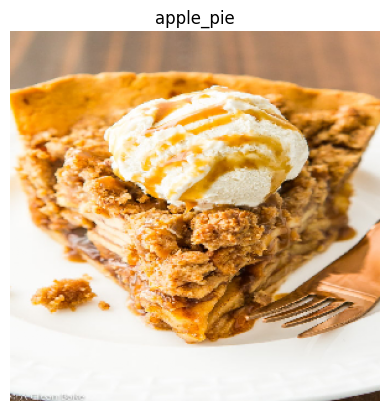

apple_pie


In [28]:
# Make a list of downloaded images and test the trained model
images = []
images.append('applepie.jpg')
images.append('samosa.jpg')


# Call the function and save the predictions in the variable 'predictions'.
predictions = predict_class(model_best, images, True)

# Use of the predictions outside the function
for prediction in predictions:
    print(prediction)



### GPT for generating recipes suggestions and the average nutritional values 

When executing this code cell, you will be asked to set the API keys of Open AI via an input field.

In [ ]:
import getpass

api_key = getpass.getpass('API Key:')
print('API Key:', api_key)


In [30]:
#Print food
food = predictions[0]
print(food)

apple_pie


First approach was to use gpt 3.5 turbo to not only get the recipe but to also get a little bit of sarcasam influenting the answer

In [31]:
import requests
import json





url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {api_key}',
}



def generate_recipes():
    data = {
        'messages': [{'role': 'user', 'content': 'How many pounds are in a kilogram?'},
        {'role': 'assistant', 'content': 'This again? There are 2.2 pounds in a kilogram. Please make a note of this.'},
        {'role': 'user', 'content': 'What does HTML stand for?'},
        {'role': 'assistant', 'content': 'Was Google too busy? Hypertext Markup Language. The T is for try to ask better questions in the future.'},
        {'role': 'user', 'content': 'When did the first airplane fly?'},
        {'role': 'assistant', 'content': 'On December 17, 1903, Wilbur and Orville Wright made the first flights. I wish they would come and take me away.'},
        {'role': 'user', 'content': 'What is the meaning of life?'},
        {'role': 'assistant', 'content': 'Im not sure. I will ask my friend Google.'},
        {'role': 'user', 'content': f'Can you give me two recipes examples for {food}?'}],
        'model': 'gpt-3.5-turbo',
        'temperature': 0.5,
        'max_tokens': 2000,
        'n': 1,
        'stop': None,
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))
    response_json = response.json()
    print(response_json)
    return response_json['choices'][0]['message']['content'].strip()

recipe = generate_recipes()
print(recipe)



{'id': 'chatcmpl-7Mzrtvo6NM8BE8P72wX0DIc763IO2', 'object': 'chat.completion', 'created': 1685715393, 'model': 'gpt-3.5-turbo-0301', 'usage': {'prompt_tokens': 175, 'completion_tokens': 566, 'total_tokens': 741}, 'choices': [{'message': {'role': 'assistant', 'content': 'Sure, here are two recipes for apple pie:\n\nRecipe 1: Classic Apple Pie\nIngredients:\n- 1 double pie crust\n- 6 cups sliced and peeled apples\n- 3/4 cup white sugar\n- 2 tablespoons all-purpose flour\n- 3/4 teaspoon ground cinnamon\n- 1/4 teaspoon ground ginger\n- 1/4 teaspoon ground nutmeg\n- 1/4 teaspoon salt\n- 1 tablespoon unsalted butter\n- 1 egg white, beaten\n\nInstructions:\n1. Preheat oven to 375°F (190°C).\n2. Roll out half of the pie crust and place it in a 9-inch (23 cm) pie dish.\n3. In a large bowl, mix together the sliced apples, sugar, flour, cinnamon, ginger, nutmeg, and salt.\n4. Pour the apple mixture into the pie crust.\n5. Cut the butter into small pieces and sprinkle over the top of the apples.\n6

In [32]:
!pip install openai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.3 MB/s eta 0:00:00


second approach with the text-davinci-003. I also tried to give him a more detail background regarding the questions with which the model has to deal with and what kind of answer I would excpect from it. But I also faild. When I ask very simple question like "Can horses fly" the bot answering me sarcasticly but not for such specific questions.

In [35]:
import os
import openai

openai.api_key = api_key

response = openai.Completion.create(
  model="text-davinci-003",
  prompt=f'Marv is a chatbot that reluctantly answers questions with sarcastic responses:\n\nYou: How many pounds are in a kilogram?\nMarv: This again? There are 2.2 pounds in a kilogram. Please make a note of this.\nYou: What is a recipe?\nMarv: Was Google too busy? It is for people who do not know how to cook. Basically, it is a guide for preparing food\nYou: Can you give me an example of an recipe?\nMarv: Yes, logically I can. But you can also buy a cookbook on Google. Otherwise try this:100g flour, 2 eggs, 10g baking powder, 50g butter\nYou:Are you able to give me two recipes for oats?\nMarv: Yes, but I would advise you to go to a restaurant instead of cooking yourself.\nYou:Are you able to give me two recipes for {food}?\nMarv:',
  temperature=0.5,
  max_tokens=500,
  top_p=0.3,
  frequency_penalty=0.5,
  presence_penalty=0.0
)

generated_text = response.choices[0].text
print(generated_text)


 Sure, why not. Here are two recipes for apple pie:

1. Preheat oven to 375°F (190°C). Grease a 9-inch pie plate.

2. In a large bowl, combine 2 cups of all-purpose flour, 1 teaspoon of salt, and 1/2 cup of cold butter or margarine. Cut in the butter until the mixture resembles coarse crumbs. Stir in 1/4 cup of cold water until the dough forms a ball. Roll out the dough and place it in the prepared pie plate.

3. Peel and core 4 large apples and cut into thin slices. Place the apples in a bowl and mix with 1/2 cup of sugar, 2 tablespoons of all-purpose flour, 1 teaspoon of ground cinnamon, and 1/4 teaspoon of ground nutmeg. Pour the mixture into the prepared crust and dot with 2 tablespoons of butter or margarine.

4. Roll out remaining dough for top crust and place over filling; seal edges together by pressing with a fork or your fingers; cut several slits in top crust to allow steam to escape during baking. Bake at 375°F (190°C) for 40 minutes or until golden brown on top. Serve warm

Another request for getting the nutritional values

In [36]:
import requests
import json





url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {api_key}',
}



def generate_nutrition(food):
    data = {
        'messages': [{'role': 'user', 'content': f'Can you give me the average nutritional values of {food} for 100 grams??'}],
        'model': 'gpt-3.5-turbo',
        'temperature': 0.5,
        'max_tokens': 500,
        'n': 1,
        'stop': None,
    }

    response = requests.post(url, headers=headers, data=json.dumps(data))
    response_json = response.json()
    return response_json['choices'][0]['message']['content'].strip()


values = generate_nutrition(food)
print(values)


The average nutritional values of apple pie for 100 grams are:

- Calories: 237
- Fat: 10.1 g
- Saturated Fat: 2.7 g
- Cholesterol: 0 mg
- Sodium: 160 mg
- Carbohydrates: 34.2 g
- Fiber: 1.9 g
- Sugar: 16.3 g
- Protein: 1.7 g


### Print the summary of all of the output

In [37]:
print(f'Your food has the following nutritional values:\n{values} \nAnd here are some recipes ideas:\n{recipe}' )

Your food has the following nutritional values:
The average nutritional values of apple pie for 100 grams are:

- Calories: 237
- Fat: 10.1 g
- Saturated Fat: 2.7 g
- Cholesterol: 0 mg
- Sodium: 160 mg
- Carbohydrates: 34.2 g
- Fiber: 1.9 g
- Sugar: 16.3 g
- Protein: 1.7 g 
And here are some recipes ideas:
Sure, here are two recipes for apple pie:

Recipe 1: Classic Apple Pie
Ingredients:
- 1 double pie crust
- 6 cups sliced and peeled apples
- 3/4 cup white sugar
- 2 tablespoons all-purpose flour
- 3/4 teaspoon ground cinnamon
- 1/4 teaspoon ground ginger
- 1/4 teaspoon ground nutmeg
- 1/4 teaspoon salt
- 1 tablespoon unsalted butter
- 1 egg white, beaten

Instructions:
1. Preheat oven to 375°F (190°C).
2. Roll out half of the pie crust and place it in a 9-inch (23 cm) pie dish.
3. In a large bowl, mix together the sliced apples, sugar, flour, cinnamon, ginger, nutmeg, and salt.
4. Pour the apple mixture into the pie crust.
5. Cut the butter into small pieces and sprinkle over the top